In [ ]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
import os

py.init_notebook_mode(connected=True)
%matplotlib inline


Using TensorFlow backend.


In [4]:
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return datetime.fromtimestamp(float(time_in_secs))

print('Data dir listing...')
dataDir = 'input/bitcoin-historical-data/'

print(os.listdir(dataDir))


Data dir listing...
['bitflyerJPY_1-min_data_2017-07-04_to_2018-03-27.csv', 'bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv', 'coinbaseUSD_1-min_data_2014-12-01_to_2018-03-27.csv', 'coincheckJPY_1-min_data_2014-10-31_to_2018-03-27.csv']


In [5]:
fileName = 'bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv'

print('Using ' + fileName + '...')
fullData = pd.read_csv(dataDir + fileName, parse_dates=True, date_parser=dateparse, index_col=[0])

print('Total null open prices: %s' % fullData['Open'].isnull().sum())

Using bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv...
Total null open prices: 0


In [6]:
fullData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3273377 entries, 2011-12-31 07:52:00 to 2018-03-27 01:00:00
Data columns (total 7 columns):
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
dtypes: float64(7)
memory usage: 199.8 MB


In [7]:
fullData.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [8]:
fullData.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2018-03-27 00:56:00,8159.21,8159.39,8153.62,8153.68,0.663192,5408.215377,8154.826880
2018-03-27 00:57:00,8159.38,8163.72,8152.81,8155.00,3.720024,30333.753144,8154.182788
2018-03-27 00:58:00,8157.47,8158.60,8130.01,8130.01,27.294436,222388.761970,8147.769162
2018-03-27 00:59:00,8145.17,8149.66,8130.01,8149.66,23.065281,187570.784940,8132.169837
2018-03-27 01:00:00,8152.26,8164.68,8151.37,8153.04,17.758130,144820.147410,8155.146220


In [9]:
data = fullData[fullData.index > pd.Timestamp('2017-01-01')][::100]

In [10]:
def print_chart(data):
    dd = data[::10]

    btc_trace = go.Scatter(x=dd.index, y=dd['Weighted_Price'], name= 'Price')
    py.iplot([btc_trace])

In [11]:
print_chart(data)

In [12]:
data['Weighted_Price'].replace(0, np.nan, inplace=True)
data['Weighted_Price'].fillna(method='ffill', inplace=True)

In [13]:
print_chart(data)

In [14]:
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted_Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [38]:

price_series = pd.Series(scaled)
price_series.pct_change()

Exception: Data must be 1-dimensional

In [15]:
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

5184 1296


In [16]:
def create_dataset_parts(dataset, proportion=0.8):
    train_size = int(len(scaled) * proportion)
    test_size = len(scaled) - train_size
    train, test = [], []
    sm1 = 0
    for i in range(len(dataset) - 1):
        sm1 += proportion
        a = dataset[i:(i + 1)]
        if sm1 >= 1:
            train.append(a)
            sm1-=1
        else:
            test.append(a)
    return np.array(train), np.array(test)

In [17]:
#train, test = create_dataset_parts(scaled)
#print(len(train), len(test))

In [18]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [19]:
look_back = 100
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

5084
1196


In [40]:
train

array([[ 0.01101782],
       [ 0.01090114],
       [ 0.01089261],
       ..., 
       [ 0.7948876 ],
       [ 0.81230974],
       [ 0.80392683]], dtype=float32)

In [20]:
(trainX.shape[0], 1, trainX.shape[1])

(5084, 1, 100)

In [21]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [41]:
train.shape

(5184, 1)

In [23]:
import timeit

start = timeit.default_timer()

epochs = 1000

model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mae', optimizer='adam')

history = model.fit(trainX, trainY, epochs=epochs, batch_size=1000, validation_data=(testX, testY), verbose=1, shuffle=True)

stop = timeit.default_timer()
totalTime = stop - start

print (str(totalTime) + " sec, ", str(totalTime/epochs) + " sec/epoch")

Train on 5084 samples, validate on 1196 samples
Epoch 1/1000
5084/5084 [==============================] - 5s 997us/step - loss: 0.3710 - val_loss: 0.0934
Epoch 2/1000
5084/5084 [==============================] - 0s 34us/step - loss: 0.3639 - val_loss: 0.0976
Epoch 3/1000
5084/5084 [==============================] - 0s 40us/step - loss: 0.3508 - val_loss: 0.1175
Epoch 4/1000
5084/5084 [==============================] - 0s 35us/step - loss: 0.3221 - val_loss: 0.2128
Epoch 5/1000
5084/5084 [==============================] - 0s 35us/step - loss: 0.2694 - val_loss: 0.3363
Epoch 6/1000
5084/5084 [==============================] - 0s 35us/step - loss: 0.2156 - val_loss: 0.3627
Epoch 7/1000
5084/5084 [==============================] - 0s 31us/step - loss: 0.1786 - val_loss: 0.3106
Epoch 8/1000
5084/5084 [==============================] - 0s 37us/step - loss: 0.1552 - val_loss: 0.2525
Epoch 9/1000
5084/5084 [==============================] - 0s 37us/step - loss: 0.1358 - val_loss: 0.2031
Epoch 

Epoch 78/1000
5084/5084 [==============================] - 0s 40us/step - loss: 0.0116 - val_loss: 0.0287
Epoch 79/1000
5084/5084 [==============================] - 0s 33us/step - loss: 0.0118 - val_loss: 0.0249
Epoch 80/1000
5084/5084 [==============================] - 0s 31us/step - loss: 0.0115 - val_loss: 0.0304
Epoch 81/1000
5084/5084 [==============================] - 0s 35us/step - loss: 0.0118 - val_loss: 0.0245
Epoch 82/1000
5084/5084 [==============================] - 0s 37us/step - loss: 0.0117 - val_loss: 0.0265
Epoch 83/1000
5084/5084 [==============================] - 0s 36us/step - loss: 0.0116 - val_loss: 0.0260
Epoch 84/1000
5084/5084 [==============================] - 0s 35us/step - loss: 0.0114 - val_loss: 0.0241
Epoch 85/1000
5084/5084 [==============================] - 0s 35us/step - loss: 0.0114 - val_loss: 0.0243
Epoch 86/1000
5084/5084 [==============================] - 0s 38us/step - loss: 0.0113 - val_loss: 0.0232
Epoch 87/1000
5084/5084 [=====================

Epoch 155/1000
5084/5084 [==============================] - 0s 34us/step - loss: 0.0103 - val_loss: 0.0243
Epoch 156/1000
5084/5084 [==============================] - 0s 32us/step - loss: 0.0103 - val_loss: 0.0190
Epoch 157/1000
5084/5084 [==============================] - 0s 38us/step - loss: 0.0103 - val_loss: 0.0194
Epoch 158/1000
5084/5084 [==============================] - 0s 41us/step - loss: 0.0102 - val_loss: 0.0236
Epoch 159/1000
5084/5084 [==============================] - 0s 40us/step - loss: 0.0108 - val_loss: 0.0223
Epoch 160/1000
5084/5084 [==============================] - 0s 35us/step - loss: 0.0104 - val_loss: 0.0219
Epoch 161/1000
5084/5084 [==============================] - 0s 34us/step - loss: 0.0107 - val_loss: 0.0333
Epoch 162/1000
5084/5084 [==============================] - 0s 36us/step - loss: 0.0110 - val_loss: 0.0190
Epoch 163/1000
5084/5084 [==============================] - 0s 34us/step - loss: 0.0104 - val_loss: 0.0262
Epoch 164/1000
5084/5084 [===========

5084/5084 [==============================] - 0s 34us/step - loss: 0.0098 - val_loss: 0.0167
Epoch 308/1000
5084/5084 [==============================] - 0s 38us/step - loss: 0.0094 - val_loss: 0.0167
Epoch 309/1000
5084/5084 [==============================] - 0s 32us/step - loss: 0.0095 - val_loss: 0.0234
Epoch 310/1000
5084/5084 [==============================] - 0s 34us/step - loss: 0.0098 - val_loss: 0.0188
Epoch 311/1000
5084/5084 [==============================] - 0s 33us/step - loss: 0.0092 - val_loss: 0.0191
Epoch 312/1000
5084/5084 [==============================] - 0s 35us/step - loss: 0.0100 - val_loss: 0.0272
Epoch 313/1000
5084/5084 [==============================] - 0s 37us/step - loss: 0.0099 - val_loss: 0.0181
Epoch 314/1000
5084/5084 [==============================] - 0s 36us/step - loss: 0.0098 - val_loss: 0.0166
Epoch 315/1000
5084/5084 [==============================] - 0s 35us/step - loss: 0.0096 - val_loss: 0.0221
Epoch 316/1000
5084/5084 [==========================

5084/5084 [==============================] - 0s 30us/step - loss: 0.0089 - val_loss: 0.0270
Epoch 460/1000
5084/5084 [==============================] - 0s 32us/step - loss: 0.0096 - val_loss: 0.0185
Epoch 461/1000
5084/5084 [==============================] - 0s 37us/step - loss: 0.0098 - val_loss: 0.0246
Epoch 462/1000
5084/5084 [==============================] - 0s 37us/step - loss: 0.0093 - val_loss: 0.0189
Epoch 463/1000
5084/5084 [==============================] - 0s 38us/step - loss: 0.0099 - val_loss: 0.0170
Epoch 464/1000
5084/5084 [==============================] - 0s 32us/step - loss: 0.0090 - val_loss: 0.0157
Epoch 465/1000
5084/5084 [==============================] - 0s 40us/step - loss: 0.0090 - val_loss: 0.0207
Epoch 466/1000
5084/5084 [==============================] - 0s 36us/step - loss: 0.0092 - val_loss: 0.0169
Epoch 467/1000
5084/5084 [==============================] - 0s 34us/step - loss: 0.0091 - val_loss: 0.0179
Epoch 468/1000
5084/5084 [==========================

5084/5084 [==============================] - 0s 37us/step - loss: 0.0091 - val_loss: 0.0198
Epoch 612/1000
5084/5084 [==============================] - 0s 33us/step - loss: 0.0089 - val_loss: 0.0183
Epoch 613/1000
5084/5084 [==============================] - 0s 33us/step - loss: 0.0086 - val_loss: 0.0150
Epoch 614/1000
5084/5084 [==============================] - 0s 33us/step - loss: 0.0086 - val_loss: 0.0226
Epoch 615/1000
5084/5084 [==============================] - 0s 38us/step - loss: 0.0087 - val_loss: 0.0148
Epoch 616/1000
5084/5084 [==============================] - 0s 35us/step - loss: 0.0088 - val_loss: 0.0150
Epoch 617/1000
5084/5084 [==============================] - 0s 39us/step - loss: 0.0085 - val_loss: 0.0156
Epoch 618/1000
5084/5084 [==============================] - 0s 35us/step - loss: 0.0086 - val_loss: 0.0160
Epoch 619/1000
5084/5084 [==============================] - 0s 36us/step - loss: 0.0084 - val_loss: 0.0159
Epoch 620/1000
5084/5084 [==========================

5084/5084 [==============================] - 0s 30us/step - loss: 0.0083 - val_loss: 0.0207
Epoch 764/1000
5084/5084 [==============================] - 0s 42us/step - loss: 0.0089 - val_loss: 0.0165
Epoch 765/1000
5084/5084 [==============================] - 0s 35us/step - loss: 0.0087 - val_loss: 0.0177
Epoch 766/1000
5084/5084 [==============================] - 0s 34us/step - loss: 0.0086 - val_loss: 0.0262
Epoch 767/1000
5084/5084 [==============================] - 0s 36us/step - loss: 0.0091 - val_loss: 0.0153
Epoch 768/1000
5084/5084 [==============================] - 0s 35us/step - loss: 0.0092 - val_loss: 0.0186
Epoch 769/1000
5084/5084 [==============================] - 0s 40us/step - loss: 0.0089 - val_loss: 0.0144
Epoch 770/1000
5084/5084 [==============================] - 0s 31us/step - loss: 0.0085 - val_loss: 0.0148
Epoch 771/1000
5084/5084 [==============================] - 0s 35us/step - loss: 0.0084 - val_loss: 0.0160
Epoch 772/1000
5084/5084 [==========================

5084/5084 [==============================] - 0s 38us/step - loss: 0.0083 - val_loss: 0.0153
Epoch 916/1000
5084/5084 [==============================] - 0s 41us/step - loss: 0.0080 - val_loss: 0.0163
Epoch 917/1000
5084/5084 [==============================] - 0s 39us/step - loss: 0.0079 - val_loss: 0.0162
Epoch 918/1000
5084/5084 [==============================] - 0s 42us/step - loss: 0.0081 - val_loss: 0.0161
Epoch 919/1000
5084/5084 [==============================] - 0s 31us/step - loss: 0.0083 - val_loss: 0.0156
Epoch 920/1000
5084/5084 [==============================] - 0s 32us/step - loss: 0.0082 - val_loss: 0.0152
Epoch 921/1000
5084/5084 [==============================] - 0s 38us/step - loss: 0.0082 - val_loss: 0.0172
Epoch 922/1000
5084/5084 [==============================] - 0s 35us/step - loss: 0.0081 - val_loss: 0.0156
Epoch 923/1000
5084/5084 [==============================] - 0s 40us/step - loss: 0.0078 - val_loss: 0.0182
Epoch 924/1000
5084/5084 [==========================

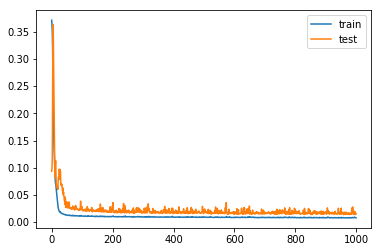

In [24]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [26]:
yhat = model.predict(testX)
#pyplot.plot(yhat, label='predict')
#pyplot.plot(testY, label='true')
#pyplot.legend()
#pyplot.show()

In [27]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [28]:
rmse = sqrt(mean_squared_error(*testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 384.573


In [29]:
divider = 10

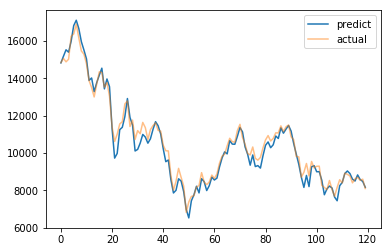

In [30]:
pyplot.plot(yhat_inverse[::divider], label='predict')
pyplot.plot(testY_inverse[::divider], label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [31]:
predictDates = data.tail(len(testX[::divider])).index

In [32]:
testY_reshape = testY_inverse[::divider].reshape(len(testY_inverse[::divider]))
yhat_reshape = yhat_inverse[::divider].reshape(len(yhat_inverse[::divider]))

In [33]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict 1-step Price')
py.iplot([predict_chart , actual_chart])

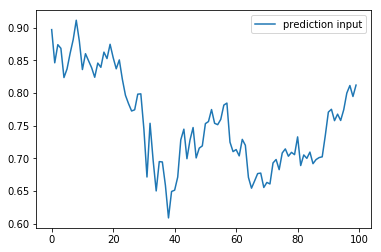

In [34]:
inpx = trainX[len(trainX)-1:len(trainX)]
n = inpx[0,0,0:len(inpx[0,0])]
pyplot.plot(n, label='prediction input')
pyplot.legend()
pyplot.show()

In [35]:
index = []
prediction = []
nxt = inpx
index.append([0])

prediction_points = 1000
#prediction.append(nxt[0,0].tolist())
for i in range(1, prediction_points):
    n = nxt[0,0, 1:len(inpx[0,0])]
    predict = model.predict(nxt, batch_size=1, verbose=0)
    n = np.append(n, [predict])
    #print(predict,n)
    nxt = np.reshape(n, (nxt.shape[0], nxt.shape[1], nxt.shape[2]))
    #print(nxt[0,0].tolist())
    index.append(i)
    prediction.append(predict[0,0].tolist())
#print(prediction)

In [36]:
#prediction_inverse = scaler.inverse_transform(np.reshape(prediction, (prediction_points - 1 ,1)))
inpx_inverse = scaler.inverse_transform(np.reshape(inpx, (len(inpx[0,0,0])  , 1)))
#actual_inverse = scaler.inverse_transform(np.reshape(test, (len(test) ,1)))
#pyplot.plot(prediction_inverse, label='predict_history')
#pyplot.plot(actual_inverse, label='actual_inverse')
pyplot.plot(inpx_inverse, label='inpx_inverse')

pyplot.legend()
pyplot.show()

TypeError: object of type 'numpy.float32' has no len()

In [ ]:
inpx